## ML models

In [5]:
import pandas as pd

### Load data

In [7]:
df_train = pd.read_csv("train_data.csv", index_col=0)
df_test = pd.read_csv("test_data.csv", index_col=0)

In [8]:
def load_data():
    X_train = df_train.drop("label", axis=1)
    y_train = df_train["label"]

    X_test = df_test.drop("label", axis=1)
    y_test = df_test["label"]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_data()

In [9]:
print(X_train.shape, X_test.shape)

(2103, 63) (902, 63)


### Decision trees

In [12]:
from sklearn import tree

In [63]:
DTC = tree.DecisionTreeClassifier(
    criterion="entropy",
    max_depth=8,
    min_samples_split=10,
    max_features="auto",
    random_state=100
)

In [64]:
DTC.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [65]:
train_score = DTC.score(X_train, y_train)
test_score = DTC.score(X_test, y_test)

print("Training accuracy: {0:5.2f}%.\
      \nTesting accuracy: {1:5.2f}%"
      .format(100*train_score, 100*test_score))

Training accuracy: 93.34%.      
Testing accuracy: 86.59%


### Radom forest

In [66]:
from sklearn.ensemble import RandomForestClassifier

In [73]:
RFC = RandomForestClassifier(
    n_estimators=100,
    criterion="entropy",
    max_depth=5,
    min_samples_split=10,
    random_state=100,
)

In [74]:
RFC.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=100, verbose=0, warm_start=False)

In [75]:
train_score = RFC.score(X_train, y_train)
test_score = RFC.score(X_test, y_test)

print("Training accuracy: {0:5.2f}%.\
      \nTesting accuracy: {1:5.2f}%"
      .format(100*train_score, 100*test_score))

Training accuracy: 96.53%.      
Testing accuracy: 93.46%


### Gradient boosting tree

In [122]:
from sklearn.ensemble import GradientBoostingClassifier

In [123]:
GBC = GradientBoostingClassifier(
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    max_depth=2, 
    random_state=100
)

In [124]:
GBC.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=100, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [125]:
train_score = GBC.score(X_train, y_train)
test_score = GBC.score(X_test, y_test)

print("Training accuracy: {0:5.2f}%.\
      \nTesting accuracy: {1:5.2f}%"
      .format(100*train_score, 100*test_score))

Training accuracy: 99.10%.      
Testing accuracy: 95.01%


In [126]:
y_test.value_counts()

company     273
profile     255
tasks       195
benefits    179
Name: label, dtype: int64

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

labels = ["company", "tasks", "profile", "benefits"]
y_pred_train = GBC.predict(X_train)
y_pred_test = GBC.predict(X_test)
cm_train = confusion_matrix(y_train, y_pred_train, labels=labels)
cm_test = confusion_matrix(y_test, y_pred_test, labels=labels)

def plot_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14, cmap=plt.cm.RdBu_r):
    """Prints a confusion matrix as a heatmap.
    
    Inputs
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
    fontsize: int
        Font size for axes labels.
        
    Outputs
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, center==0, fmt="d", cmap=cmap)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label', fontsize=fontsize)
    plt.xlabel('Predicted label', fontsize=fontsize)

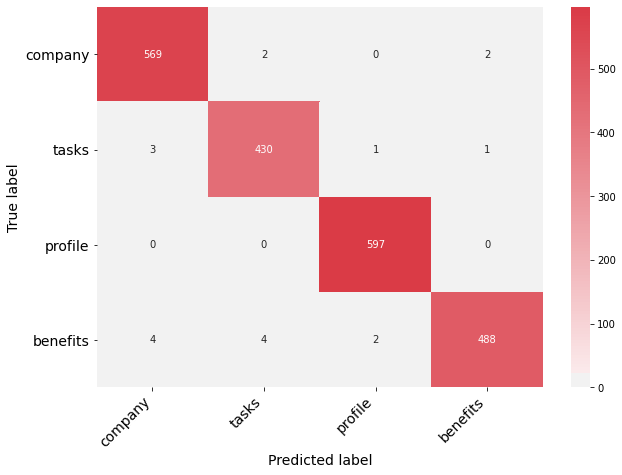

In [150]:
plot_confusion_matrix(confusion_matrix=cm_train, class_names=labels)

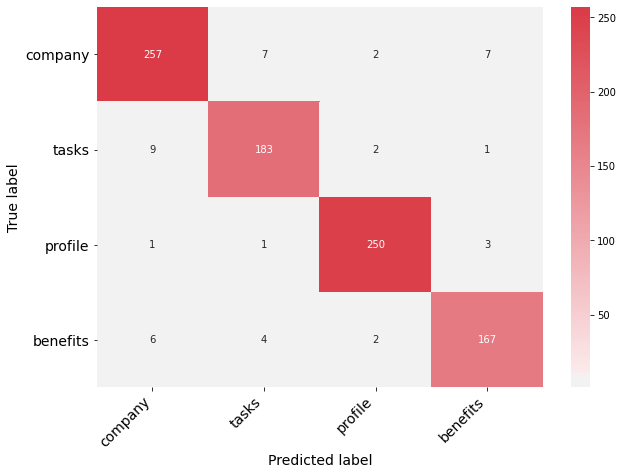

In [152]:
plot_confusion_matrix(confusion_matrix=cm_test, class_names=labels)

In [49]:
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

In [36]:
label_column = "label"

model_file = "model.h5"
history_file = "history.csv"
stats_file = "stats.cav"

In [37]:
# make stats file for train data
df_stats = df_train.describe().loc[["mean", "std"]].transpose()
df_stats.to_csv(stats_file)

In [14]:
def norm(df, train_stats):
    """Normalized based on mean and std of training data
    
    Args:
        df: input features
        train_stats (df): statistics of train data, from pd.DataFrame.describe function
    
    Returns: 
        Normalized df
    """
    return (df - train_stats['mean']) / train_stats['std']

In [52]:
label_dict = {
    "company": 0,
    "tasks": 1,
    "profile": 2,
    "benefits": 3
}

In [67]:
def make_train_data():
    """make training inputs.
    
    Return:
        train_data: normilized features
        train_labels: target label
    """
    df_input_pm = df_train.iloc[np.random.permutation(len(df_train))]
    features = df_input_pm.drop(label_column, axis=1)
    train_features_norm = norm(features, df_stats)
    train_label = to_categorical(df_input_pm[label_column].map(label_dict))
    return train_features_norm, train_label

In [94]:
def build_model(X, learning_rate=0.001):
    """Build neural networks model.
    2-layers full-connected model with 8 neurons each.
    
    Args:
        X: input features
        learning_rate (float): learning rate of the learning algorithm

    Returns:
        NN: fully connected neural networks model
    """
    NN = Sequential()
    NN.add(Dense(16, activation='relu', input_dim=X.shape[1]))
    NN.add(Dropout(0.2))
    NN.add(Dense(8, activation='relu'))
    NN.add(Dropout(0.2))
    NN.add(Dense(4, activation='softmax'))
    
    NN.compile(
        optimizer=SGD(lr=0.005, momentum=0.8),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return NN

In [103]:
clear_session()

train_data, train_labels = make_train_data()
model = build_model(train_data)
history = model.fit(
    train_data, 
    train_labels,
    validation_split = 0.3,
    epochs=1000,
    verbose=3
)

Train on 1472 samples, validate on 631 samples
Epoch 1/1000
Epoch 2/1000
Epoch 3/1000
Epoch 4/1000
Epoch 5/1000
Epoch 6/1000
Epoch 7/1000
Epoch 8/1000
Epoch 9/1000
Epoch 10/1000
Epoch 11/1000
Epoch 12/1000
Epoch 13/1000
Epoch 14/1000
Epoch 15/1000
Epoch 16/1000
Epoch 17/1000
Epoch 18/1000
Epoch 19/1000
Epoch 20/1000
Epoch 21/1000
Epoch 22/1000
Epoch 23/1000
Epoch 24/1000
Epoch 25/1000
Epoch 26/1000
Epoch 27/1000
Epoch 28/1000
Epoch 29/1000
Epoch 30/1000
Epoch 31/1000
Epoch 32/1000
Epoch 33/1000
Epoch 34/1000
Epoch 35/1000
Epoch 36/1000
Epoch 37/1000
Epoch 38/1000
Epoch 39/1000
Epoch 40/1000
Epoch 41/1000
Epoch 42/1000
Epoch 43/1000
Epoch 44/1000
Epoch 45/1000
Epoch 46/1000
Epoch 47/1000
Epoch 48/1000
Epoch 49/1000
Epoch 50/1000
Epoch 51/1000
Epoch 52/1000
Epoch 53/1000
Epoch 54/1000
Epoch 55/1000
Epoch 56/1000
Epoch 57/1000
Epoch 58/1000
Epoch 59/1000
Epoch 60/1000
Epoch 61/1000
Epoch 62/1000
Epoch 63/1000
Epoch 64/1000
Epoch 65/1000
Epoch 66/1000
Epoch 67/1000
Epoch 68/1000
Epoch 69/1

Epoch 540/1000
Epoch 541/1000
Epoch 542/1000
Epoch 543/1000
Epoch 544/1000
Epoch 545/1000
Epoch 546/1000
Epoch 547/1000
Epoch 548/1000
Epoch 549/1000
Epoch 550/1000
Epoch 551/1000
Epoch 552/1000
Epoch 553/1000
Epoch 554/1000
Epoch 555/1000
Epoch 556/1000
Epoch 557/1000
Epoch 558/1000
Epoch 559/1000
Epoch 560/1000
Epoch 561/1000
Epoch 562/1000
Epoch 563/1000
Epoch 564/1000
Epoch 565/1000
Epoch 566/1000
Epoch 567/1000
Epoch 568/1000
Epoch 569/1000
Epoch 570/1000
Epoch 571/1000
Epoch 572/1000
Epoch 573/1000
Epoch 574/1000
Epoch 575/1000
Epoch 576/1000
Epoch 577/1000
Epoch 578/1000
Epoch 579/1000
Epoch 580/1000
Epoch 581/1000
Epoch 582/1000
Epoch 583/1000
Epoch 584/1000
Epoch 585/1000
Epoch 586/1000
Epoch 587/1000
Epoch 588/1000
Epoch 589/1000
Epoch 590/1000
Epoch 591/1000
Epoch 592/1000
Epoch 593/1000
Epoch 594/1000
Epoch 595/1000
Epoch 596/1000
Epoch 597/1000
Epoch 598/1000
Epoch 599/1000
Epoch 600/1000
Epoch 601/1000
Epoch 602/1000
Epoch 603/1000
Epoch 604/1000
Epoch 605/1000
Epoch 606/

In [187]:
import matplotlib.pyplot as plt

df_history = pd.DataFrame(history.history)
def plot_history(df_history):
    """Plot learning curve for both training and testing data.
    """
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    plt.figure(figsize=(8,5))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(df_history['accuracy'], lw=4, label='Train Error')
    plt.plot(df_history['val_accuracy'], lw=4, label = 'Val Error')
    plt.legend()
    plt.show()

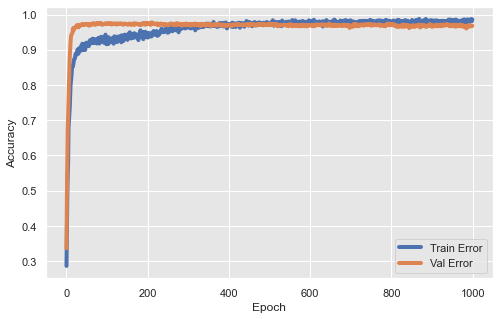

In [188]:
plot_history(df_history)

In [106]:
print(df_history.tail().describe())

           loss  accuracy  val_loss  val_accuracy
count  5.000000  5.000000  5.000000      5.000000
mean   0.060487  0.983832  0.179835      0.967670
std    0.006856  0.002421  0.001228      0.000868
min    0.053039  0.980978  0.178392      0.966720
25%    0.055919  0.981658  0.178610      0.966720
50%    0.060266  0.984375  0.180489      0.968304
75%    0.062321  0.985734  0.180828      0.968304
max    0.070892  0.986413  0.180855      0.968304
